In [78]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

Below I read in the two csvs of the data we scraped and concatenate them so that we have data from both the 2013 and 2014 seasons. 

In [79]:
#Insight1 Do teams shoot earlier 
merged_2014=pd.read_csv("merged_shots_14.csv")
merged_2013=pd.read_csv("merged_shots_13.csv")
frames = [merged_2014,merged_2013]
combined = pd.concat(frames)


In [80]:
# Data Exploration and Mutation 


I first make a variable that holds the current score deficit of the shooting team. In order to look at the effect of shot distance on whether the basket goes in, I create a kde plot below, much like in HW3. Those who don't understand basketball might be surprised, but there is a midrange region where it's much harder to make a basket. 

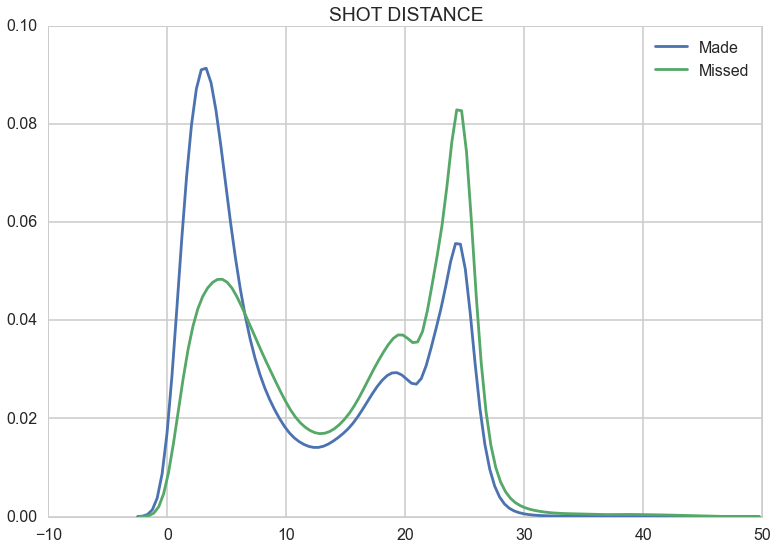

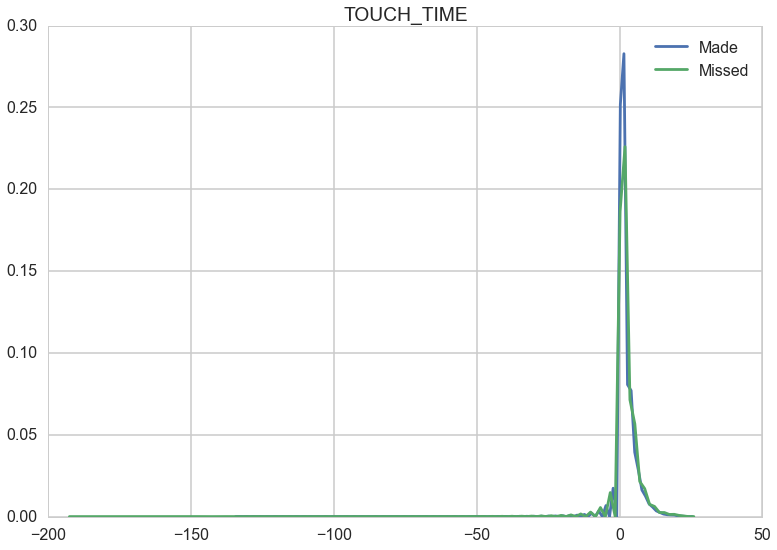

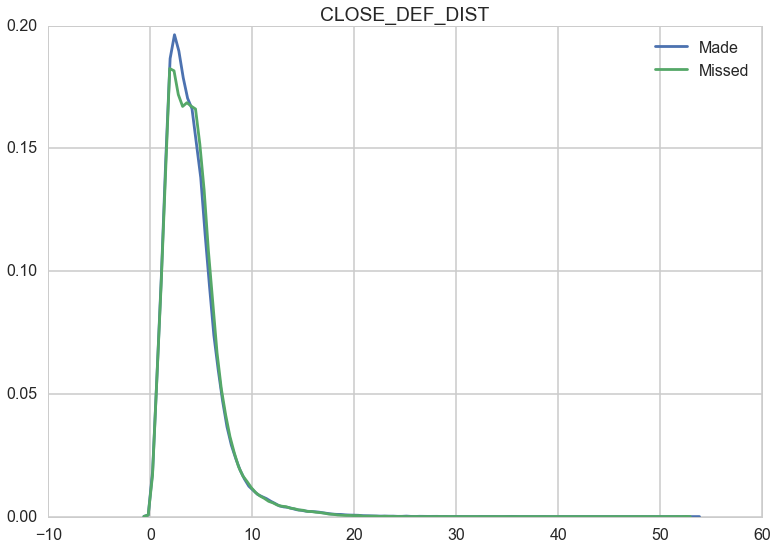

In [81]:
combined["SCOREDIFF_BEFORE_SHOT"] = combined["SCOREMARGIN"]-combined["PTS"]

made = combined["SHOT_MADE_FLAG"].values==1
sns.kdeplot(combined["SHOT_DIST"][made],label="Made")
sns.kdeplot(combined["SHOT_DIST"][~made],label="Missed")
plt.title("SHOT DISTANCE")
plt.figure()
sns.kdeplot(combined["TOUCH_TIME"][made],label="Made")
sns.kdeplot(combined["TOUCH_TIME"][~made],label="Missed")
plt.title("TOUCH_TIME")
plt.figure()
sns.kdeplot(combined["CLOSE_DEF_DIST"][made],label="Made")
sns.kdeplot(combined["CLOSE_DEF_DIST"][~made],label="Missed")
plt.title("CLOSE_DEF_DIST")


Here I create a unique ID and two dummy variables to distinguish shots that are farther than 22 feet from the basket and shots that are closer than 22 feet from the basket because it is clear to see that there are two distinct zones where making a basket is easier. 

In [82]:
combined["unique"] = range(0,len(combined))
combined["fartherthan22"] = combined["SHOT_DIST"]>22
combined["closerthan10"] = combined["SHOT_DIST"]<10


Here I reformat the hight variable so that it can be used as a float. 

In [83]:
combined["off_height"]=combined["off_height"].str.replace('-','.')
combined["def_height"]=combined["def_height"].str.replace('-','.')

I want to see which columns have null values 

In [84]:
combined.isnull().sum()

Unnamed: 0                        0
EVENTMSGACTIONTYPE                0
EVENTMSGTYPE                      0
EVENTNUM                          0
GAME_ID                           0
HOMEDESCRIPTION              189115
NEUTRALDESCRIPTION           401495
PCTIMESTRING                      0
PERIOD_x                          0
PERSON1TYPE                       0
PERSON2TYPE                       0
PERSON3TYPE                       0
PLAYER1_ID                        0
PLAYER1_NAME                      0
PLAYER1_TEAM_ABBREVIATION         0
PLAYER1_TEAM_CITY                 0
PLAYER1_TEAM_ID                   0
PLAYER1_TEAM_NICKNAME             0
PLAYER2_ID                        0
PLAYER2_NAME                 295316
PLAYER2_TEAM_ABBREVIATION    295316
PLAYER2_TEAM_CITY            295316
PLAYER2_TEAM_ID              295316
PLAYER2_TEAM_NICKNAME        295316
PLAYER3_ID                        0
PLAYER3_NAME                 378906
PLAYER3_TEAM_ABBREVIATION    378906
PLAYER3_TEAM_CITY           

Rather than having these variables each have multiple levels, I decided to make each of their levels a dummy variable using the function todummy. I thought this might make it
easier to interpret the results

In [85]:
todummies = [u'ACTION_TYPE',
       u'SHOT_TYPE', u'SHOT_ZONE_BASIC', u'SHOT_ZONE_AREA']
for i in todummies:
    dummies=pd.get_dummies(combined[i])
    frames = [combined,dummies]
    combined = pd.concat(frames,axis=1)
combined = combined[pd.notnull(combined['off_height'])]

Here I make a list of all the variables I want to include in my model, many of which are the dummy variables just created. 

In [86]:
relevant = [u'CLOSE_DEF_DIST',u'PTS_TYPE',u'SHOT_DIST', u'TOUCH_TIME',u'Alley Oop Dunk Shot', u'Alley Oop Layup shot', u'Driving Bank Hook Shot', u'Driving Bank shot', u'Driving Dunk Shot', u'Driving Finger Roll Layup Shot', u'Driving Hook Shot', u'Driving Jump shot', u'Driving Layup Shot', u'Driving Reverse Layup Shot', u'Driving Slam Dunk Shot', u'Dunk Shot', u'Fadeaway Bank shot', u'Fadeaway Jump Shot', u'Finger Roll Layup Shot', u'Floating Jump shot', u'Hook Bank Shot', u'Hook Shot', u'Jump Bank Hook Shot', u'Jump Bank Shot', u'Jump Hook Shot',
       u'Jump Shot', u'Layup Shot', u'Pullup Bank shot', u'Pullup Jump shot', u'Putback Dunk Shot', u'Putback Layup Shot', u'Putback Reverse Dunk Shot', u'Putback Slam Dunk Shot', u'Reverse Dunk Shot', u'Reverse Layup Shot', u'Reverse Slam Dunk Shot', u'Running Bank Hook Shot', u'Running Bank shot', u'Running Dunk Shot', u'Running Finger Roll Layup Shot', u'Running Hook Shot', u'Running Jump Shot', u'Running Layup Shot', u'Running Reverse Layup Shot', u'Running Slam Dunk Shot',
       u'Running Tip Shot', u'Slam Dunk Shot', u'Step Back Jump shot', u'Tip Shot', u'Turnaround Bank Hook Shot', u'Turnaround Bank shot', u'Turnaround Fadeaway shot', u'Turnaround Hook Shot', u'Turnaround Jump Shot', u'2PT Field Goal', u'3PT Field Goal', u'Above the Break 3', u'Backcourt', u'In The Paint (Non-RA)', u'Left Corner 3', u'Mid-Range', u'Restricted Area', u'Right Corner 3', u'Back Court(BC)', u'Center(C)', u'Left Side Center(LC)', u'Left Side(L)', u'Right Side Center(RC)',
       u'Right Side(R)',"fartherthan22","closerthan10"]
target = ["SHOT_MADE_FLAG"]

I split the dataset into training and testing sets, much like we've done in the homeworks 

In [87]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(combined.shape[0]), train_size=0.7)
mask=np.ones(combined.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)


Here I define the functions we defined in the homeworks to both fit models and do a cross validated parameter search for their hyperparameters

In [88]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV

def cv_optimize(clf, parameters, X, Y, n_folds=5,score_func=None):
    gs = sklearn.grid_search.GridSearchCV(clf, param_grid=parameters, cv=n_folds,scoring=score_func)
    gs.fit(X, Y)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best


def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
#     print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# Training and Testing Different Models

In [89]:
%%time
alphas = range(1,10)
clf, Xtrain, ytrain, Xtest, ytest = do_classify(Ridge(), {"alpha": alphas}, combined,relevant, u'SHOT_MADE_FLAG',1,score_func="mean_squared_error", mask=mask)

using mask
BEST PARAMS {'alpha': 6}
############# based on standard predict ################
Accuracy on training data: 0.12
Accuracy on test data:     0.12
########################################################
CPU times: user 1min 37s, sys: 4.75 s, total: 1min 41s
Wall time: 1min 40s


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


The accuracy of this model isn't good because it's not clasifying binarily. It's predicting values outside of 0 or 1. Below I calculate mean square error of the model and it's accuracy. 

In [90]:
print mean_squared_error(ytest, clf.predict(Xtest))
predicted = clf.predict(Xtest)
binarypredict = []
for i in predicted:
    if i>=.5:
        binarypredict.append(1)
    else:
        binarypredict.append(0)

print np.mean(ytest==binarypredict)


0.217937769437
0.653200308545


MSE of the ridge model is lower and the accuracy is higher than other models we've seen online, which have had accuracies of about .6544. This is great. Below I store the split. 

In [91]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [92]:
cees = range(1,10)
clflogitridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2"), {"C": cees}, combined,relevant, u'SHOT_MADE_FLAG',1,score_func="mean_squared_error", reuse_split=reuse_split)


using reuse split
BEST PARAMS {'C': 1}
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.65
########################################################


In [93]:
probs = clflogitridge.predict_proba(Xtest)
p0 = probs[:,0]
p1 = probs[:,1]
print mean_squared_error(p1, ytest)
binarypredict = []
for i in p1:
    if i>=.5:
        binarypredict.append(1)
    else:
        binarypredict.append(0)

print np.mean(ytest==binarypredict)



0.217861283852
0.652344180448


The MSE of and accuracy of the logistic model are virtually identical to the model above. Below I use this model to predict the probability of every shot in the dataset and store this variable as a column. This will allow us to see how players performance and shot selection changes over time

In [94]:
probs = clflogitridge.predict_proba(combined[relevant])
p0 = probs[:,0]
p1 = probs[:,1]
combined["SHOT_PROB"]=p1



# Insights

The first thing I want to look into is how much time it takes for teams to shoot and whether that changes throughout the course of the game. 

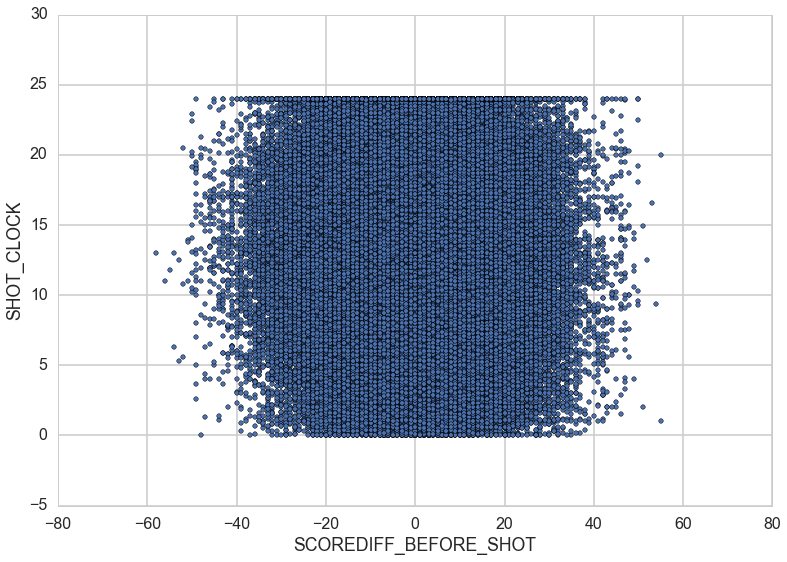

In [95]:
combined.plot("SCOREDIFF_BEFORE_SHOT","SHOT_CLOCK",kind="scatter")

I don't see any trend in particular but I think it probably varies by quarter. Below I create a new variable called POE which is the difference between the binary indicator of the shot going in and the probability. Similar to MSE, I use this metric to capture how a team performs w.r.t its expectations. 

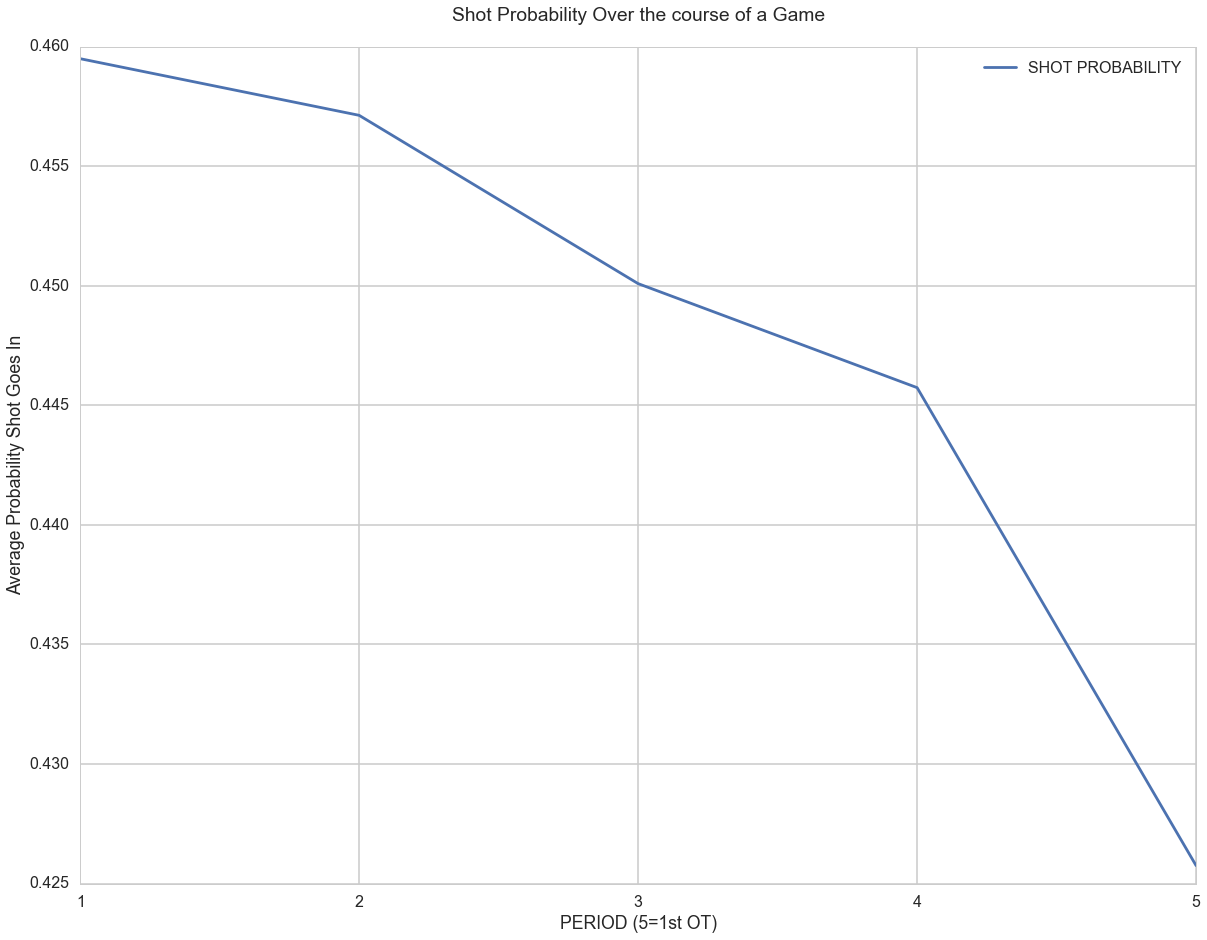

In [120]:
combined["POE"]=combined["SHOT_MADE_FLAG"]-combined["SHOT_PROB"]
relevantcolumns = ["SCOREDIFF_BEFORE_SHOT","SHOT_CLOCK","SHOT_PROB","PERIOD_x","SHOT_MADE_FLAG","POE"]
selected = combined[relevantcolumns]
grouped_period = selected.groupby(["PERIOD_x"]).agg("mean")
grouped= grouped_period[grouped_period.index<=5]
plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
plt.plot(grouped.index,grouped.SHOT_PROB,label="SHOT PROBABILITY")
plt.xticks(grouped.index)
plt.xlabel("PERIOD (5=1st OT)")
plt.ylabel("Average Probability Shot Goes In")
plt.title("Shot Probability Over the course of a Game\n")
plt.legend()
plt.savefig('shotprob.png')



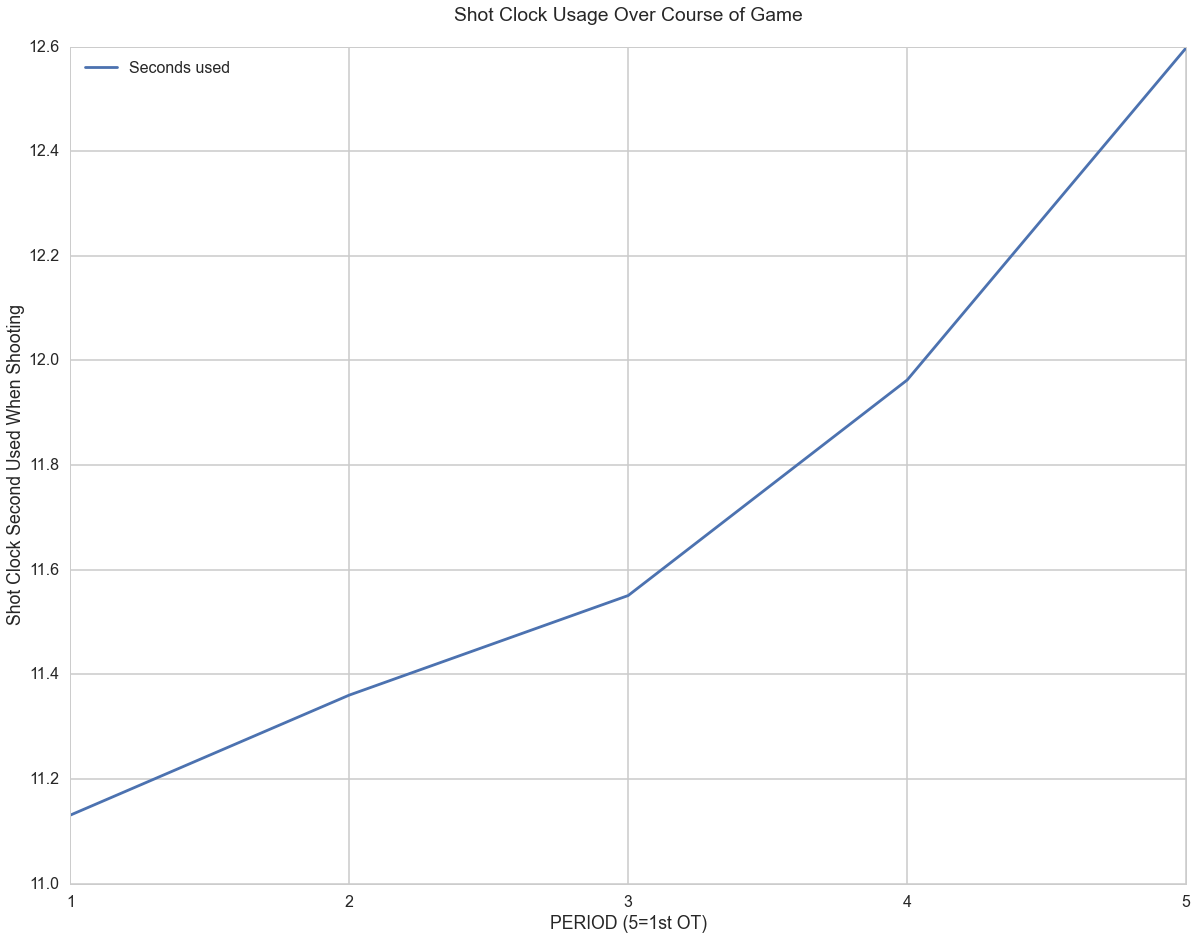

In [125]:

plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
plt.plot(grouped.index,24-grouped.SHOT_CLOCK,label="Seconds used")
plt.xticks(grouped.index)
plt.xlabel("PERIOD (5=1st OT)")
plt.ylabel("Shot Clock Second Used When Shooting")
plt.title("Shot Clock Usage Over Course of Game\n")
plt.legend(loc=2)
plt.savefig('shotclock.png')

Very interesting to see that teams use up more time per posession over the course of the game and teams take lower percentage shots as the game progresses. This is probably due to fatigue. 

Below I plot a couple other metrics over the course of a game. I want to come back to these at a later data for more indepth research outside the scope of this project. 

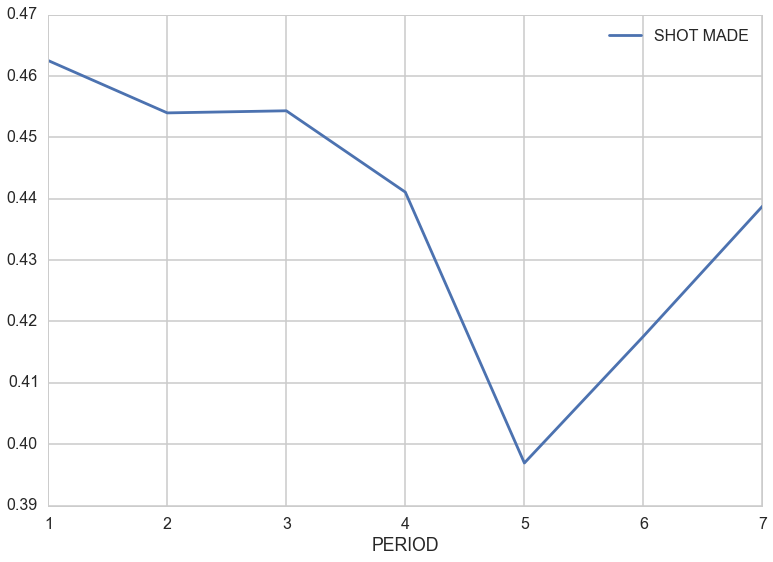

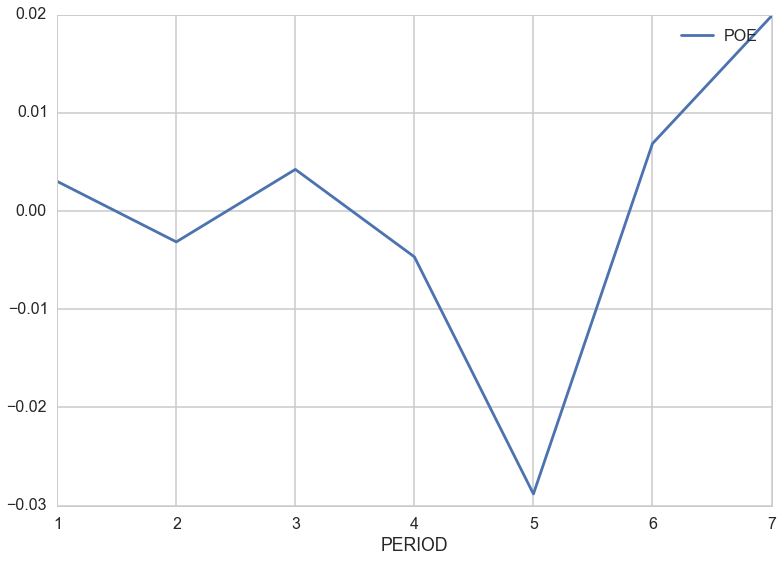

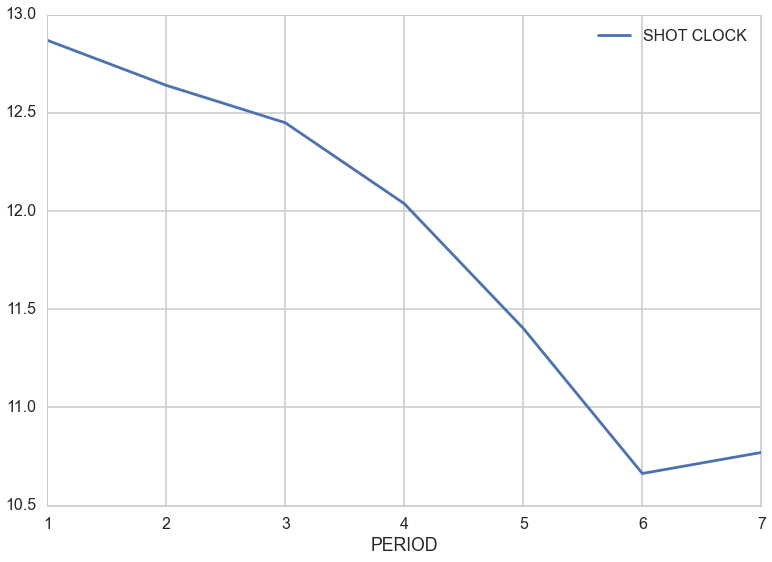

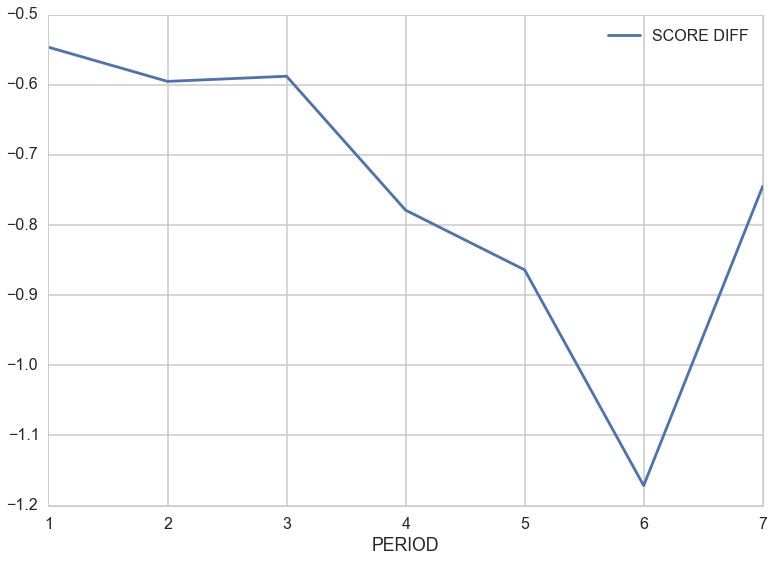

In [97]:


plt.plot(grouped_period.index,grouped_period.SHOT_MADE_FLAG,label="SHOT MADE")
plt.xlabel("PERIOD")
plt.legend()
plt.figure()
plt.plot(grouped_period.index,grouped_period.POE,label="POE")
plt.xlabel("PERIOD")
plt.legend()
plt.figure()
plt.plot(grouped_period.index,grouped_period.SHOT_CLOCK,label="SHOT CLOCK")
plt.xlabel("PERIOD")
plt.legend()
plt.figure()
plt.plot(grouped_period.index,grouped_period.SCOREDIFF_BEFORE_SHOT,label="SCORE DIFF")
plt.xlabel("PERIOD")
plt.legend()


Now I want to see how certain shot stats change with respect to both period and the difference in score. My hypothesis is that teams will change their strategies depending on whether they're ahead or behind

In [98]:


grouped = selected.groupby(["SCOREDIFF_BEFORE_SHOT","PERIOD_x"],as_index=False)
# grouped = selected.groupby(["SCOREDIFF_BEFORE_SHOT","PERIOD_x"],as_index=False)
aggregated = grouped.agg(['mean', 'median','count',"std"])
aggregated = grouped.agg(['mean', 'median','count',"std"])
aggregated_bigsamples = aggregated[aggregated["SHOT_CLOCK"]["count"]>=5]
aggregated_bigsamples["INDEX"] = aggregated_bigsamples.index
unzipped = zip(*aggregated_bigsamples["INDEX"].values)
difference = list(unzipped[0])
period = list(unzipped[1])
aggregated_bigsamples["SCOREDIFF"]=difference
aggregated_bigsamples["PERIOD"]=period


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-v

In [99]:
df = pd.DataFrame({"scorediff":aggregated_bigsamples["SCOREDIFF"].values,
                   "shotclock":aggregated_bigsamples["SHOT_CLOCK"]["mean"].values,
                   "period":aggregated_bigsamples["PERIOD"].values,
                    "poe":aggregated_bigsamples["POE"]["mean"].values,
                   "shotmade":aggregated_bigsamples["SHOT_MADE_FLAG"]["mean"].values,
                   "shotcount":aggregated_bigsamples["SHOT_MADE_FLAG"]["count"].values,
                    "shotprob":aggregated_bigsamples["SHOT_PROB"]["mean"].values})
df= df[(df.scorediff>=-30) & (df.scorediff<=30)]
first = df[df.period==1]
second = df[df.period==2]
third = df[df.period==3]
fourth = df[df.period==4]
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import normalize


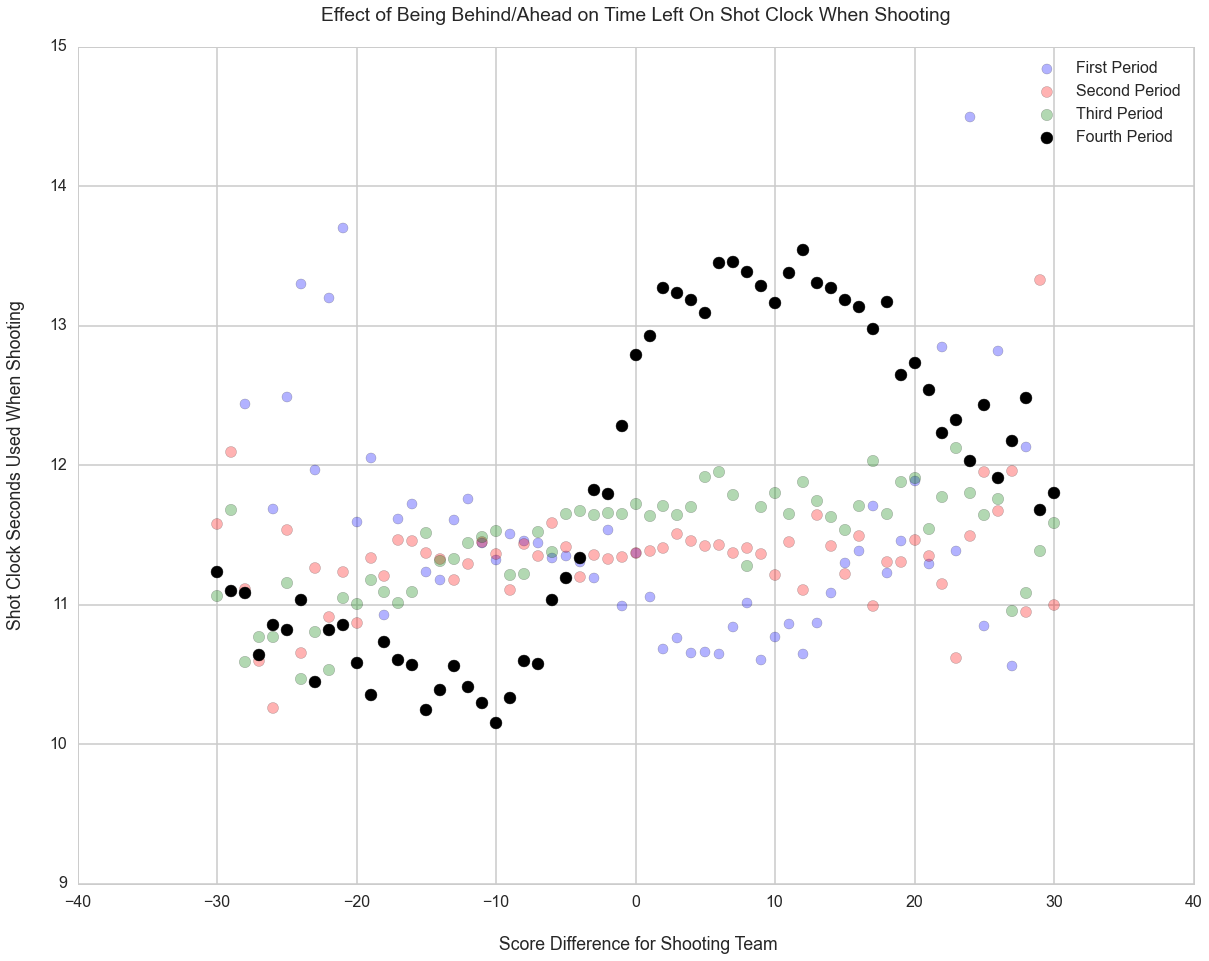

In [124]:
plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(first.scorediff,24-first.shotclock,c="b",s=100,label="First Period",alpha=.3)
plt.scatter(second.scorediff,24-second.shotclock,c="r",s=120,label="Second Period",alpha=.3)
plt.scatter(third.scorediff,24-third.shotclock,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,24-fourth.shotclock,c="black",s=140,label="Fourth Period")
plt.ylabel('Shot Clock Seconds Used When Shooting \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')
plt.legend()
plt.savefig('shotclockperquarter.png')



Interestingly, teams do seem to shoot earlier when losing and later when winning, but only in the fourth quarter. That makes sense though because that's when the game is most time-sensitive. The question now is whether this effect makes teams shoot better or worse or neither. 

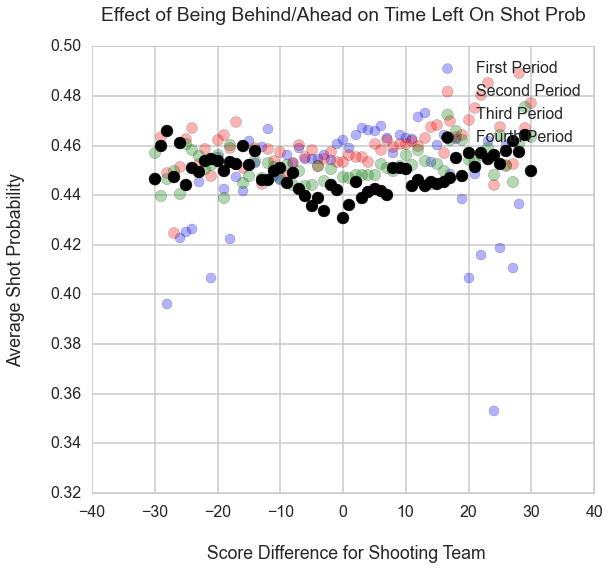

In [126]:
%matplotlib inline

plt.figure(num=None, figsize=(9, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(first.scorediff,first.shotprob,c="b",s=100,label="First Period",alpha=.3)
plt.scatter(second.scorediff,second.shotprob,c="r",s=120,label="Second Period",alpha=.3)
plt.scatter(third.scorediff,third.shotprob,c="g",s=130,label="Third Period",alpha=.3)
plt.scatter(fourth.scorediff,fourth.shotprob,c="black",s=140,label="Fourth Period")
plt.ylabel('Average Shot Probability \n')
plt.xlabel('\n Score Difference for Shooting Team')
plt.title('Effect of Being Behind/Ahead on Time Left On Shot Prob\n')
plt.legend()
# plt.savefig('shotprobperscoreperquarter.png')







Adjusting for mean fourth quarter shot probability, it does appear like this change in strategy is correlated with worse shot probability. The question is really whether this change in strategy is the cause of the worse shot probability. My intuition says that theyre both due to an external third factor but I can't say for sure. 

The rest of the code below is just more plotting of things I thought might have relationships. They aren't relevant for our insights. However, I will leave them commented in case I want to go back to work on them another time. 

In [102]:
# plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
# # plt.scatter(first.scorediff,first.shotprob,c="b",s=100,label="First Period",alpha=.3)
# # plt.scatter(second.scorediff,second.shotprob,c="r",s=120,label="Second Period",alpha=.3)
# # plt.scatter(third.scorediff,third.shotprob,c="g",s=130,label="Third Period",alpha=.3)
# plt.scatter(fourth.scorediff,fourth.shotprob,c="orange",s=140,label="Fourth Period",alpha=.3)
# plt.ylabel('Shot Probability \n')
# plt.xlabel('\n Score Difference for Shooting Team')
# plt.title('Effect of Being Behind/Ahead on Shot Probability \n')
# plt.legend()

In [103]:
# plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(first.scorediff,first.poe,c="b",s=100,label="First Period",alpha=.3)
# plt.scatter(second.scorediff,second.poe,c="r",s=120,label="Second Period",alpha=.3)
# plt.scatter(third.scorediff,third.poe,c="g",s=130,label="Third Period",alpha=.3)
# plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Fourth Period",alpha=.3)
# plt.ylabel('Shot POE \n')
# plt.xlabel('\n Score Difference for Shooting Team')
# plt.title('Effect of Being Behind/Ahead on Shot POE \n')
# plt.legend()

In [104]:
# plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Fourth Period",alpha=.3)
# plt.ylabel('Shot POE \n')
# plt.xlabel('\n Score Difference for Shooting Team')
# plt.title('Effect of Being Behind/Ahead in the Fourth Quarter on Shot POE \n')
# plt.legend()

In [105]:
# plt.figure()
# plt.scatter(fourth.scorediff,fourth.shotclock-np.mean(fourth.shotclock),c="orange",s=140,label="Shotclock in 4th")
# plt.legend()
# #mean-centered shotclock 

In [106]:
# plt.figure()
# plt.scatter(fourth.scorediff,fourth.shotprob-np.mean(fourth.shotprob),c="orange",s=140,label="Probability in 4th")
# plt.legend()
# #mean centered shot probability 

In [107]:
# plt.figure()
# plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Poe in 4th")
# plt.legend()
# #fourth quarter points relative to expectation

In [108]:

# plt.figure()
# plt.scatter(fourth.scorediff,fourth.shotmade-np.mean(fourth.shotmade),c="orange",s=140,label="Made in 4th")
# plt.legend()


In [109]:
#now with respect to shotclock rather than score

# plt.figure()
# plt.scatter(fourth.shotclock,fourth.shotprob-np.mean(fourth.shotprob),c="orange",s=140,label="Prob in 4th")
# plt.legend()

# plt.figure()
# plt.scatter(fourth.shotclock,fourth.poe,c="orange",s=140,label="Poe in 4th")
# plt.legend()

# plt.figure()
# plt.scatter(fourth.shotclock,fourth.shotmade-np.mean(fourth.shotmade),c="orange",s=140,label="Average Made in 4th")
# plt.legend()
# plt.show()


# plt.figure()
# plt.scatter(fourth.shotclock,fourth.scorediff,c="orange",s=140,label="Difference in 4th")
# plt.legend()
# plt.show()




In [110]:
# plt.figure()
# plt.scatter(fourth.scorediff,fourth.poe,c="orange",s=140,label="Poe in 4th")
# plt.legend()

In [111]:
# plt.figure()
# plt.scatter(fourth.shotclock,fourth.poe,c="orange",s=140,label="Poe in 4th")
# plt.legend()


In [112]:
# plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

# # plt.scatter(first.scorediff,first.poe,c="b",s=100,label="First Period",alpha=.3)
# plt.scatter(second.scorediff,second.poe,c="r",s=120,label="Second Period",alpha=.3)
# # plt.scatter(third.scorediff,third.poe,c="g",s=130,label="Third Period",alpha=.3)
# plt.scatter(fourth.scorediff,fourth.poe-np.mean(fourth.poe),c="orange",s=140,label="Fourth Period",alpha=.3)
# # plt.ylabel('Average Seconds Left on the Shot Clock When Shooting \n')
# # plt.xlabel('\n Score Difference for Shooting Team')
# # plt.title('Effect of Being Behind/Ahead on Time Left On Shot Clock When Shooting \n')
# plt.legend(loc=4)
